In [1]:
import GPy
import optunity
import sobol
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Task 2

In [4]:
def f(x, y):
    return x**2-x + y**2 + y-np.cos(2*np.pi*x - np.pi) - np.cos(2*np.pi*y + np.pi) + 2.5

In [65]:
x = np.linspace(-6,6,2000)
y = np.linspace(-6,6,2000)
X,Y = np.meshgrid(x,y)

In [141]:
f_xy= f(X,Y)

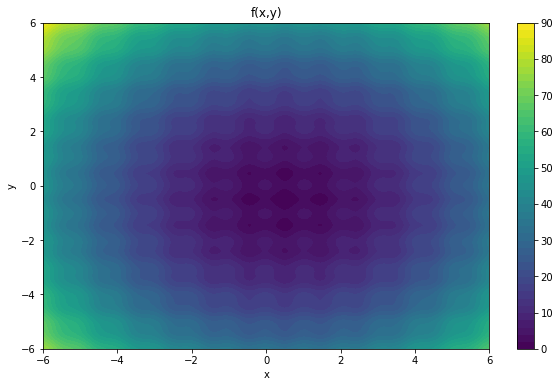

In [139]:
fig = plt.figure(figsize=(10,6))
plt.contourf(X, Y, f_xy,50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y)')
plt.colorbar()
plt.show()

In [159]:
#Expected Improvement:
def u(x,y,gp=GP_model):
    q=np.array([[x,y]])
    Ebest=min(gp.Y)
    mean,var=gp.predict(q)
    std=np.sqrt(var)
    g=(Ebest-mean)/std
    return std*(g*scipy.stats.norm.cdf(g)+scipy.stats.norm.pdf(g))

In [180]:
number_of_samples = 30
parameterUpperLimits = np. array ([6 ,6])
parameterLowerLimits = np. array ([ -6 , -6])
Q=[]
for i in range ( number_of_samples ):
    x,y = sobol.i4_sobol(2 ,i)[0]*(parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits
    Q.append([x,y])
train=np.array(Q)
Q=train.copy()

In [167]:
#calculate the true values
E=f(*Q.T).reshape(-1,1)

In [168]:
GP_model=GPy.models.GPRegression(Q,E,kernel=GPy.kern.RBF(2) + GPy.kern.White(2))

In [163]:
coord=np.vstack((X,Y)).reshape(2,-1).T

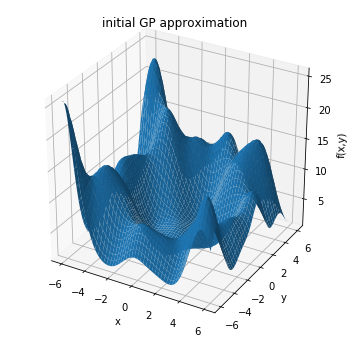

In [78]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, GP_model.predict(coord)[0].reshape(X.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('initial GP approximation')
plt.show()

In [169]:
#optimization
for i in range(30):
    _, details, _ = optunity.maximize(u, num_evals=100, x=[-6, 6], y=[-6, 6])
    best_ind=np.where(details.call_log['values']==details.optimum)[0][0]
    x,y=details.call_log['args']['x'][best_ind],details.call_log['args']['y'][best_ind]
    Q=np.append(Q,[[x,y]],axis=0)
    E=f(*Q.T).reshape(-1,1)
    GP_model=GPy.models.GPRegression(Q,E,kernel=GPy.kern.RBF(2) + GPy.kern.White(2))
    #Print the true function values and the function values predicted by the GP as a function of iteration number
    #-Which values were asked for?

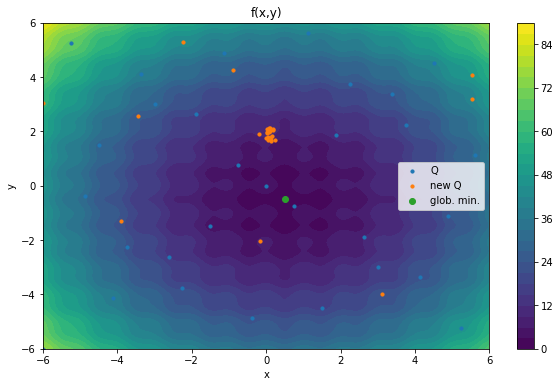

In [171]:
fig = plt.figure(figsize=(10,6))
plt.contourf(X, Y,f_xy,30)
plt.colorbar()
plt.scatter(*Q[:30].T,s=10,label='Q')
plt.scatter(*Q[30:].T,s=10,label='new Q')
plt.scatter(.5,-.5,label='glob. min.')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y)')
plt.legend()
plt.show()

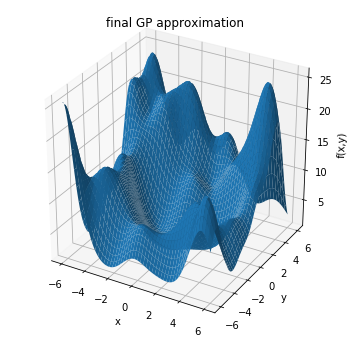

In [179]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, GP_model.predict(coord)[0].reshape(X.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('final GP approximation')
plt.show()

In [182]:
#repeat experiment with two utility functions
def varGP(x,y,gp=GP_model):
    q=np.array([[x,y]])
    return gp.predict(q)[1]

In [184]:
#optimization
for i in range(30):
    _, details, _ = optunity.maximize(u if i%2==0 else varGP, num_evals=100, x=[-6, 6], y=[-6, 6])
    best_ind=np.where(details.call_log['values']==details.optimum)[0][0]
    x,y=details.call_log['args']['x'][best_ind],details.call_log['args']['y'][best_ind]
    Q=np.append(Q,[[x,y]],axis=0)
    E=f(*Q.T).reshape(-1,1)
    GP_model=GPy.models.GPRegression(Q,E,kernel=GPy.kern.RBF(2) + GPy.kern.White(2))

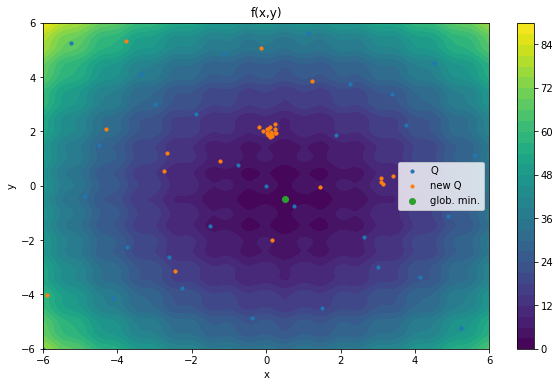

In [185]:
fig = plt.figure(figsize=(10,6))
plt.contourf(X, Y,f_xy,30)
plt.colorbar()
plt.scatter(*Q[:30].T,s=10,label='Q')
plt.scatter(*Q[30:].T,s=10,label='new Q')
plt.scatter(.5,-.5,label='glob. min.')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y)')
plt.legend()
plt.show()

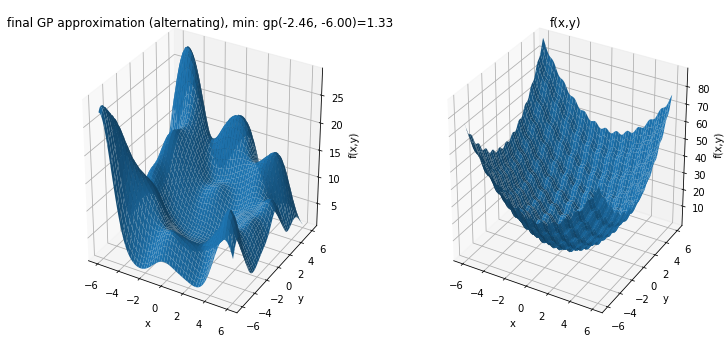

In [205]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
val=GP_model.predict(coord)[0]
ax.plot_surface(X, Y, val.reshape(X.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ind=np.argmin(val)
ax.set_title('final GP approximation (alternating), min: gp(%.2f, %.2f)=%.2f'%(*coord[ind],min(val)))
ax = fig.add_subplot(122, projection='3d')
val=GP_model.predict(coord)[0]
ax.plot_surface(X, Y,f_xy)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('f(x,y)')
plt.show()

In [198]:
#As a baseline, also compute 60 values of f(x, y) for uniformly random points in [−6, 6]^2 
#and compare their minimum with the best value found by Bayesian optimization
q_uni=12*np.random.random((2,60))-6
min(f(q_uni[0],q_uni[1]))

1.5138900496600467

# Task 3

In [2]:
import time
import scipy.sparse 
import scipy.sparse.linalg
import scipy.spatial

In [24]:
def generalized_exponential_kernel(data, rho, gamma, max_distance):
    """Compute the generalized exponential kernel matrix.

    :param data: data matrix
    :param rho: parameter rho of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert rho > 0
    limit = np.exp(-8)#np.exp(-np.sqrt(max_distance/rho)**(2*gamma))
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(-(np.sqrt(np.sum((data - k)**2,axis=1)/rho**2))**gamma)
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:,None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K

def compute_alpha(train_x, train_y, tau, rho, gamma, max_distance):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param rho: parameter rho of the gaussian kernel
    :return: alpha vector
    """
    print("building input kernel matrix")
    K = generalized_exponential_kernel(train_x, rho, gamma, max_distance)
    print("sparsity: %.2f%%" % (float(100*K.nnz) / (K.shape[0]*K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:,None])
    print("solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    print("done computing alpha")
    return alpha[0]


In [25]:
class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, rho, gamma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.rho = rho
        self.gamma = gamma
        self.scale = -1. / rho**(gamma/2)
        self.max_distance = 4.0*rho

    def train(self, train_x, train_y):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(np.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau, self.rho, self.gamma, self.max_distance)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = np.asarray(self.tree.query_ball_point(pred_x, self.max_distance), dtype=np.dtype("i8"))
        dist = np.sum((self.train_x[indices]-pred_x)**2, axis=1)
        kappa = np.exp(self.scale*dist**(self.gamma/2))
        pred_y = np.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(np.float32)
        return np.array([self.predict_single(x) for x in pred_x])


In [26]:
KernelRidgeRegressors={}

In [27]:
def kernel_ridge_regression(tau, rho, gamma):
    # Load the image.
    im_orig = np.squeeze(plt.imread("cc_90.png"))
    
    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = np.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = np.where(im != 0)
    unknown_ind = np.where(im == 0)
    known_x = np.array(known_ind).transpose()
    known_y = np.array(im[known_ind])
    pred_x = np.array(unknown_ind).transpose()
    # All coordinates
    coord=np.indices(im.shape).reshape(2,-1).T
    # Train and predict with the given regressor.
    start = time.time()
    print("training...")
    r = KernelRidgeRegressor(tau, rho, gamma)
    #saving kernel matrices
    try:
        r = KernelRidgeRegressors[tau,rho, gamma]
    except KeyError:
        r.train(known_x, known_y)
        KernelRidgeRegressors[tau,rho, gamma] = r
    print("done training")
    # pickle.dump(r, open("regressor.p", "wb"))
    # r = pickle.load(open("regressor.p", "rb"))
    print("predicting...")
    #pred_y = r.predict(pred_x)
    y = r.predict(coord)
    print("done predicting")

    # Write the predicted values back into the image and show the result.
    im = y.reshape(im_orig.shape)
    stop = time.time()
    print("Train and predict took %.02f seconds." % (stop-start))
    #print(im.shape)
    plt.figure(figsize=(6,8))
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    plt.title(r'$\tau=%.2e, \rho=%.3f, \gamma=%.3f$'%(tau,rho,gamma))
    plt.savefig("restored/res_%s_%s_%s.png"%(tau,rho,gamma))
    return im

* Solving $Ax = b$ for $x$ is generally faster than computing the matrix inverse $x = A^{−1}b$ explicitly. In this case Conjugate Gradient iteration is used for solving the linear equation system.
* Sparse matrices are used to speed up the computation since the Kernel matrix has many zero entries

# Task 4

In [7]:
B=plt.imread('charlie-chaplin.jpg')

In [8]:
def COR(tau,rho,gamma,B=B):
    A=kernel_ridge_regression(tau,rho,gamma)
    numerator,denominatorA,denominatorB=0,0,0
    A_bar,B_bar=A.mean(),B.mean()
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            numerator+=(A[i,j]-A_bar)*(B[i,j]-B_bar)
            denominatorA+=(A[i,j]-A_bar)**2
            denominatorB+=(B[i,j]-B_bar)**2
    denominator=np.sqrt(denominatorA)*np.sqrt(denominatorB)
    return numerator/denominator

In [9]:
number_of_samples = 30
parameterUpperLimits = np.array([1,7,4])
parameterLowerLimits = np.array([.005,1,1])
thetas=[]
for i in range(number_of_samples):
    params = sobol.i4_sobol(3, i)[0]*(parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits
    thetas.append(params)
thetas=np.array(thetas)

hyperparameters: [0.005 1.    1.   ]
training...
building input kernel matrix
sparsity: 0.24%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 12.26 seconds.
hyperparameters: [0.5025 4.     2.5   ]
training...
building input kernel matrix
sparsity: 0.31%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 15.77 seconds.
hyperparameters: [0.75125 2.5     3.25   ]
training...
building input kernel matrix
sparsity: 0.09%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 15.37 seconds.
hyperparameters: [0.25375 5.5     1.75   ]
training...
building input kernel matrix
sparsity: 1.17%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 15.52 seconds.
hyperparameters: [0.378125 3.25     2.875   ]
training...
building input kernel matrix
sparsity: 0.17%
solvin

 C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


hyperparameters: [0.96890625 4.5625     3.90625   ]
training...
building input kernel matrix
sparsity: 0.22%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 16.69 seconds.
hyperparameters: [0.72015625 3.0625     3.15625   ]
training...
building input kernel matrix
sparsity: 0.14%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 16.11 seconds.
hyperparameters: [0.22265625 6.0625     1.65625   ]
training...
building input kernel matrix
sparsity: 1.60%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 15.59 seconds.
hyperparameters: [0.16046875 1.9375     2.59375   ]
training...
building input kernel matrix
sparsity: 0.08%
solving sparse system
done computing alpha
done training
predicting...
done predicting
Train and predict took 15.70 seconds.
hyperparameters: [0.65796875 4.9375     1.09375   ]
training...


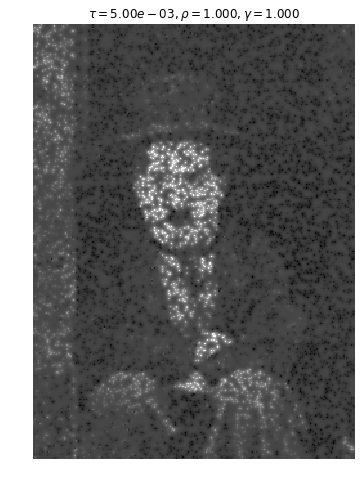

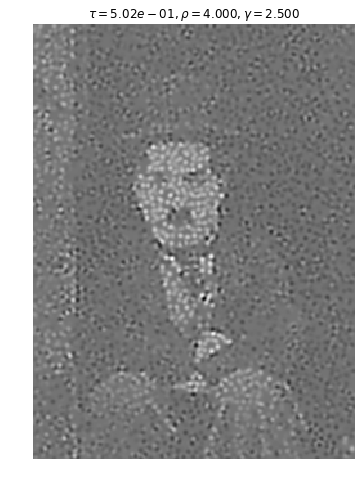

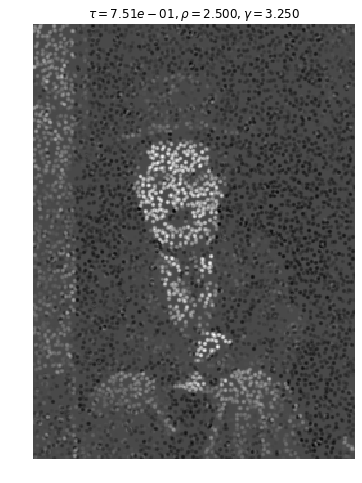

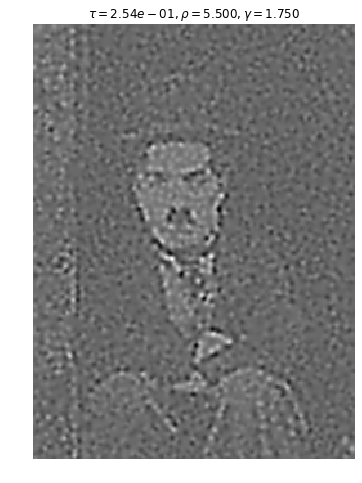

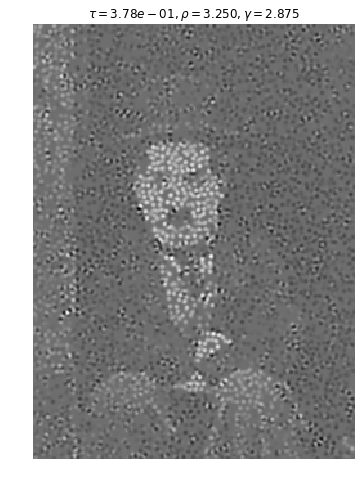

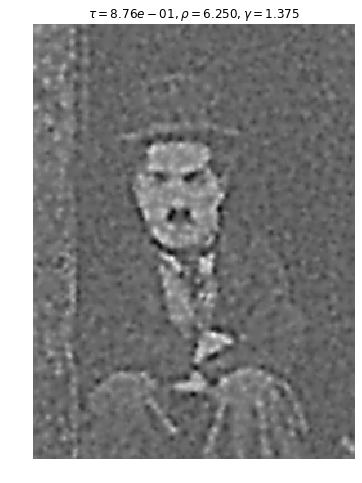

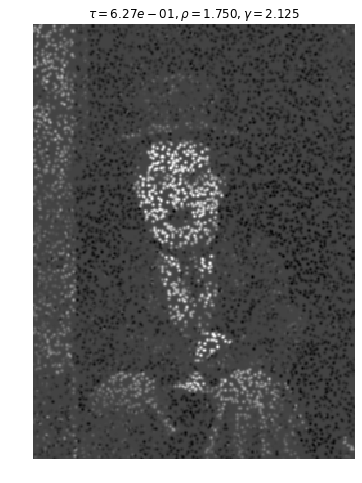

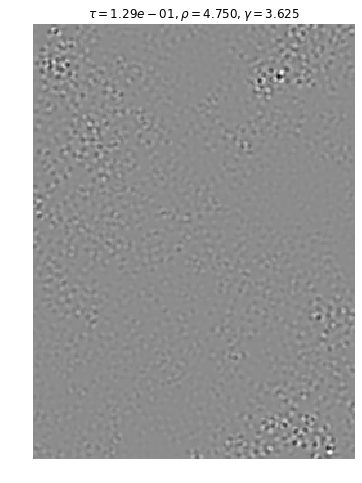

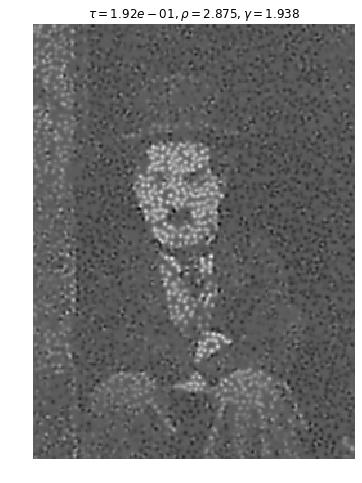

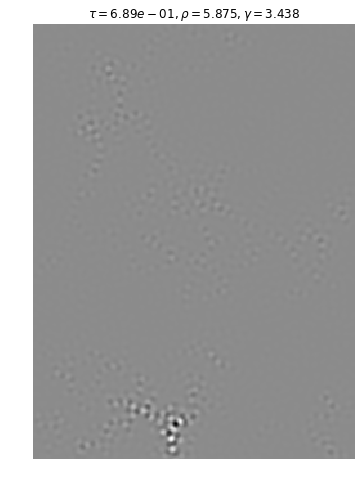

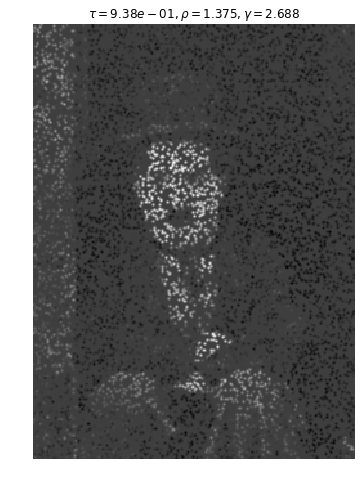

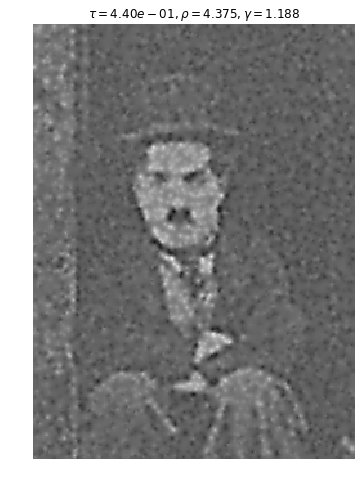

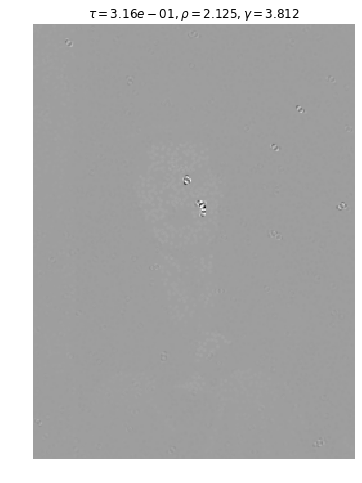

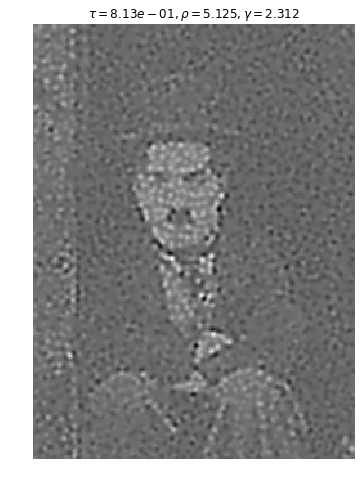

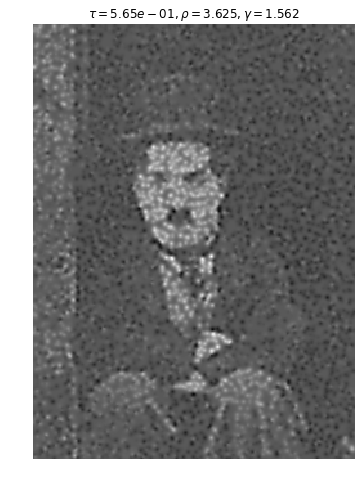

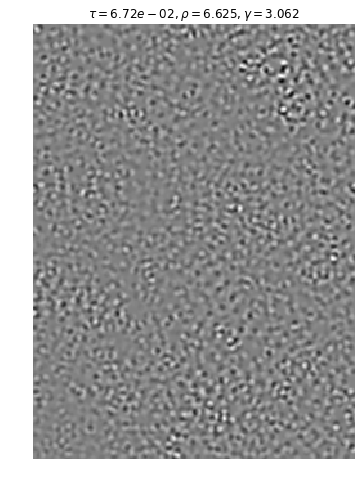

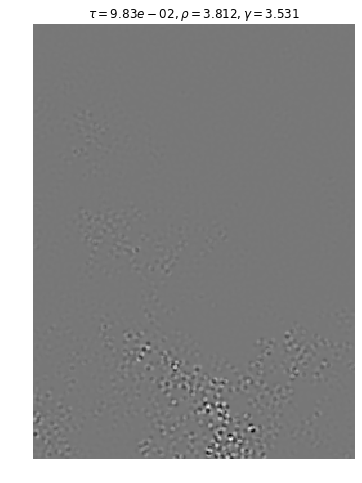

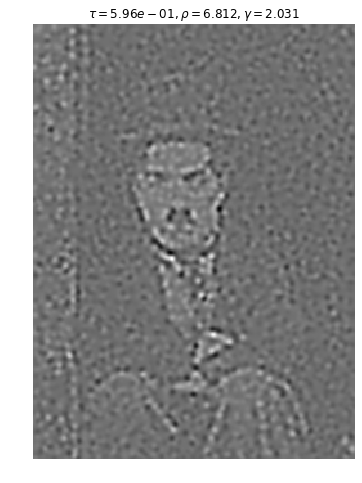

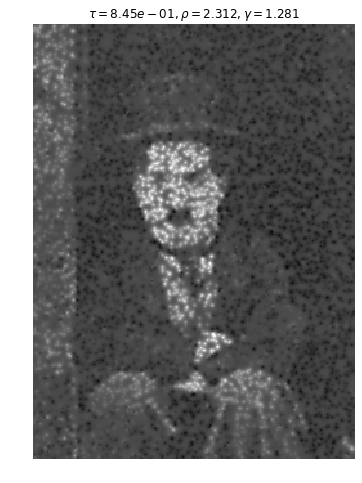

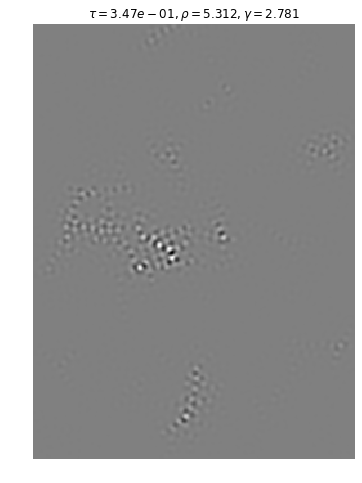

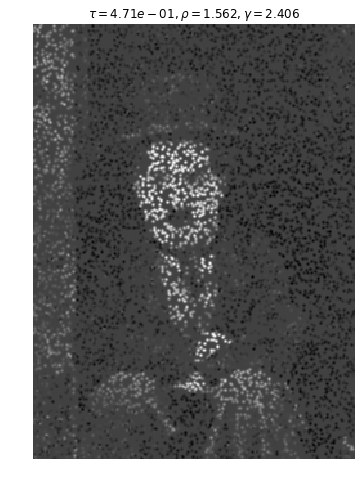

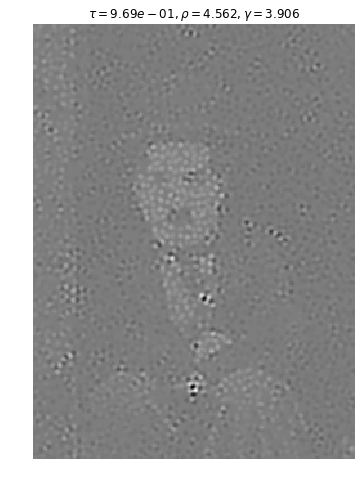

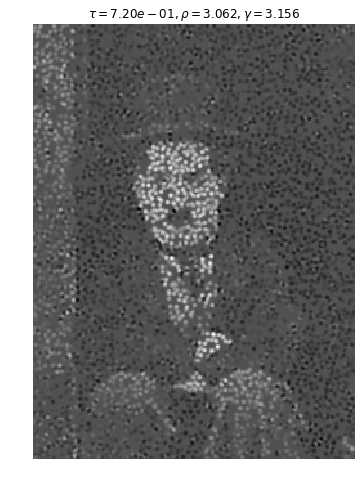

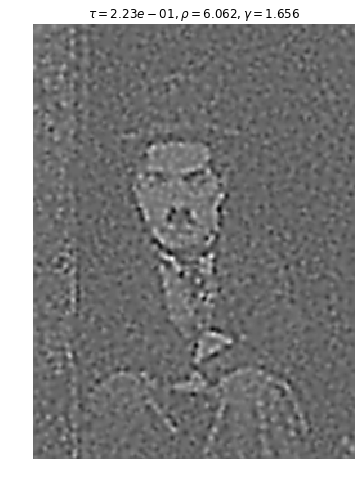

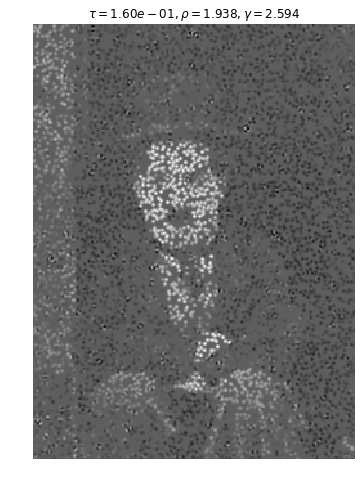

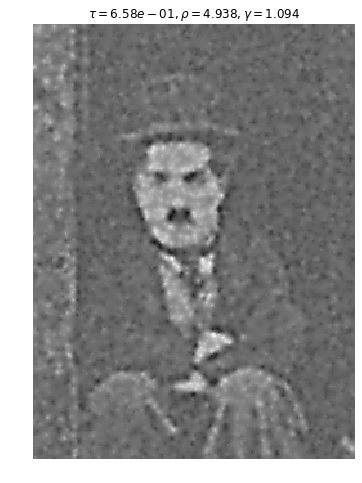

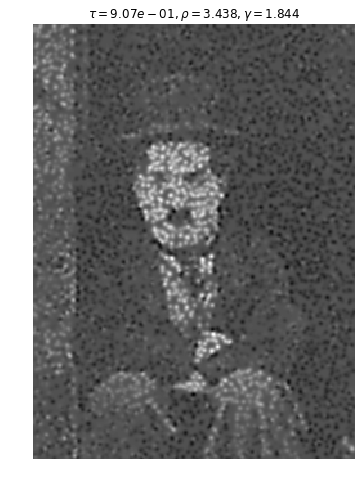

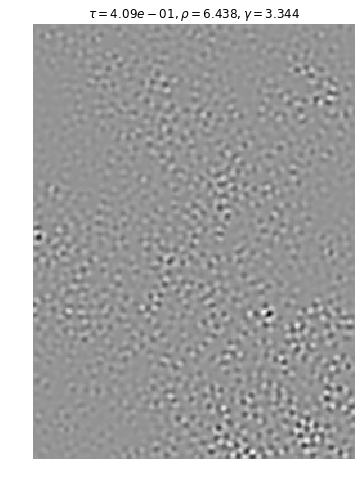

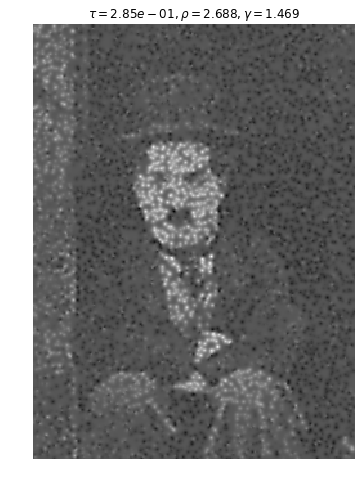

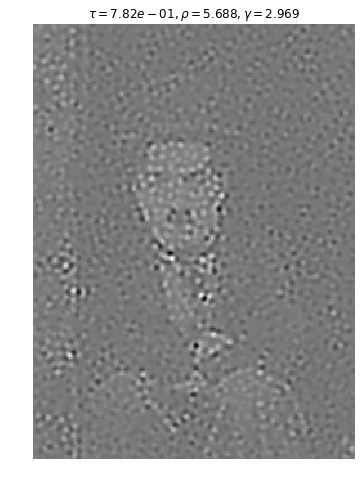

In [28]:
#create training data
cors=[]
for i in range(number_of_samples):
    print('hyperparameters:',thetas[i])
    cors.append(COR(*thetas[i]))
cors=np.array(cors)

In [29]:
np.savetxt('correlations.txt',cors)

In [35]:
GP2=GPy.models.GPRegression(thetas,cors.reshape(-1,1))#,kernel=GPy.kern.Matern52)